# Classification - penguins



In [1]:
# Load libraries

# Data manipulation
import pandas as pd
import numpy as np

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Classification Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# Error handeling
#from sklearn.utils._testing import ignore_warnings
#from sklearn.exceptions import ConvergenceWarning

# External functions
from functions import calculate_metrics


In [2]:
# Load the data
df=pd.read_csv('penguins_lter.csv')
df=df.loc[:,['Island', 'Culmen Length (mm)', 'Culmen Depth (mm)', 'Flipper Length (mm)', 'Body Mass (g)', 'Sex', 'Species']]
df

,Island,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Species
0,Torgersen,39.1,18.7,181.0,3750.0,MALE,Adelie Penguin (Pygoscelis adeliae)
1,Torgersen,39.5,17.4,186.0,3800.0,FEMALE,Adelie Penguin (Pygoscelis adeliae)
2,Torgersen,40.3,18.0,195.0,3250.0,FEMALE,Adelie Penguin (Pygoscelis adeliae)
3,Torgersen,NaN,NaN,NaN,NaN,NaN,Adelie Penguin (Pygoscelis adeliae)
4,Torgersen,36.7,19.3,193.0,3450.0,FEMALE,Adelie Penguin (Pygoscelis adeliae)
...,...,...,...,...,...,...,...
339,Biscoe,NaN,NaN,NaN,NaN,NaN,Gentoo penguin (Pygoscelis papua)
340,Biscoe,46.8,14.3,215.0,4850.0,FEMALE,Gentoo penguin (Pygoscelis papua)
341,Biscoe,50.4,15.7,222.0,5750.0,MALE,Gentoo penguin (Pygoscelis papua)
342,Biscoe,45.2,14.8,212.0,5200.0,FEMALE,Gentoo penguin (Pygoscelis papua)


## Description of the dataset

The penguin's dataset contains measurements of three different species of penguins: Adelie (0), Gentoo (1) and Chinstrap (2). These measurements were collected from the Palmer Archipelago in Antarctica. The dataset includes the following features which will be used for the prediction pourpose:

- Culmen Length (mm): The length of the penguin's culmen.
- Culmen Depth (mm): The depth of the penguin's culmen.
- Flipper Length (mm): The length of the penguin's flipper.
- Body Mass (g): The body mass of the penguin.
- Island: island name (Dream, Torgersen, or Biscoe) in the Palmer Archipelago (Antarctica)
- Sex: penguin sex

The target vector:
- Species: The species of the penguin (Adelie, Chinstrap, Gentoo).


In [3]:
# mapping the Species
spec = df['Species'].unique()
df['Species'] = df['Species'].map({spec[0]: 'Adelie', spec[1]: 'Chinstrap', spec[2]: 'Gentoo'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Island               344 non-null    object 
 1   Culmen Length (mm)   342 non-null    float64
 2   Culmen Depth (mm)    342 non-null    float64
 3   Flipper Length (mm)  342 non-null    float64
 4   Body Mass (g)        342 non-null    float64
 5   Sex                  334 non-null    object 
 6   Species              344 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


### Missingness

Verifying the number of samples and checking the completeness of the data.

In [4]:
## Change all missing variables to nan
df.replace(to_replace=".",
           value=np.nan, inplace=True)
display(df.isna().sum())
df.dropna(inplace=True, thresh=3)
df.info()
df.shape


Island                  0
Culmen Length (mm)      2
Culmen Depth (mm)       2
Flipper Length (mm)     2
Body Mass (g)           2
Sex                    11
Species                 0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 342 entries, 0 to 343
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Island               342 non-null    object 
 1   Culmen Length (mm)   342 non-null    float64
 2   Culmen Depth (mm)    342 non-null    float64
 3   Flipper Length (mm)  342 non-null    float64
 4   Body Mass (g)        342 non-null    float64
 5   Sex                  333 non-null    object 
 6   Species              342 non-null    object 
dtypes: float64(4), object(3)
memory usage: 21.4+ KB


(342, 7)

Two rows were removed from the dataset because they contained no information about the penguins' features. Additionally, there were eight missing values in the Sex column. Since this missing data appeared to be completely random (MCAR), these values were filled with the majority class (MALE) as part of the pipeline process.

## Exploratory Data Analysis (EDA)

The dataset contains 4 numerical continues features describing penguin's body measurments and 2 categorical variables of Sex and origin island. 

### Numerical features

Descriptive statistics for all variables are presented below.

In [5]:
num_features = df.columns[1:5]
df.describe()

,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g)
count,342.000000,342.000000,342.000000,342.000000
mean,43.921930,17.151170,200.915205,4201.754386
std,5.459584,1.974793,14.061714,801.954536
min,32.100000,13.100000,172.000000,2700.000000
25%,39.225000,15.600000,190.000000,3550.000000
50%,44.450000,17.300000,197.000000,4050.000000
75%,48.500000,18.700000,213.000000,4750.000000
max,59.600000,21.500000,231.000000,6300.000000


The histograms show the distribution of features among different penguin classes, with all studied variables following a normal distribution as mean and median value are close to each other.

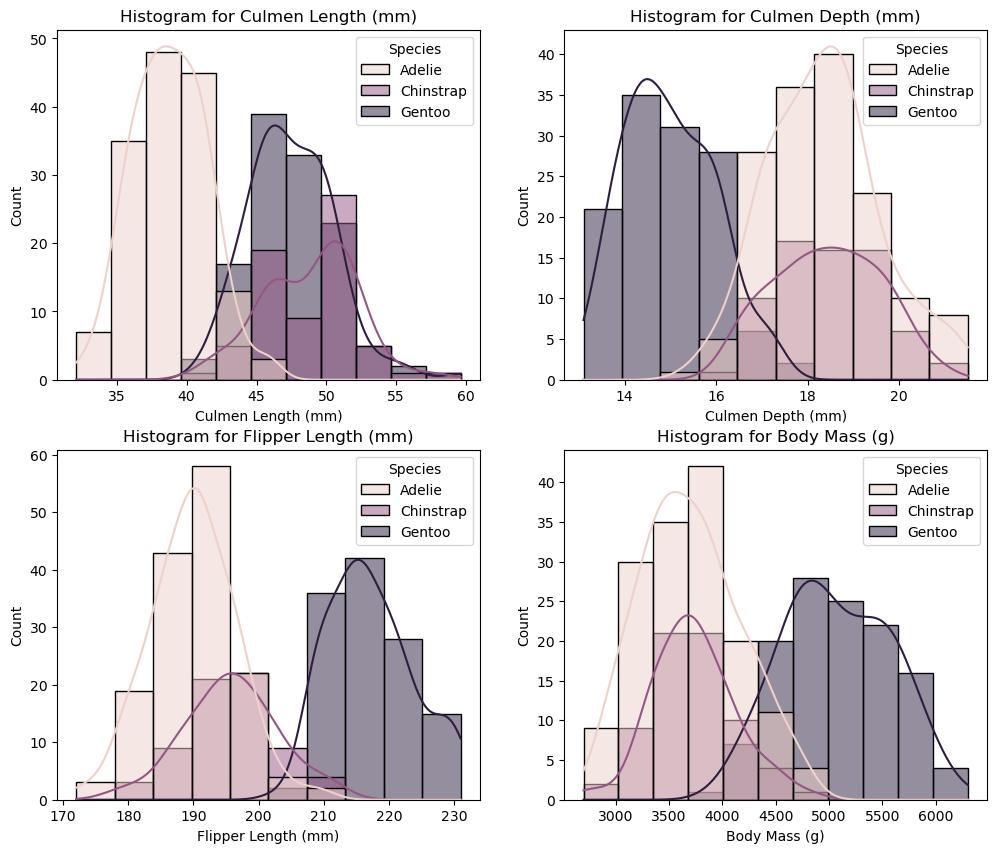

In [6]:
palette = [sns.cubehelix_palette()[i] for i in [0,3,5]]

fig, axs = plt.subplots(2,2, figsize=(12, 10))
for f, ax in zip(num_features, axs.flat):
    sns.histplot(data=df, x=f, ax=ax, kde=True, hue='Species', palette=palette, legend=True)
    ax.set_title(f"Histogram for {f}")
plt.show()


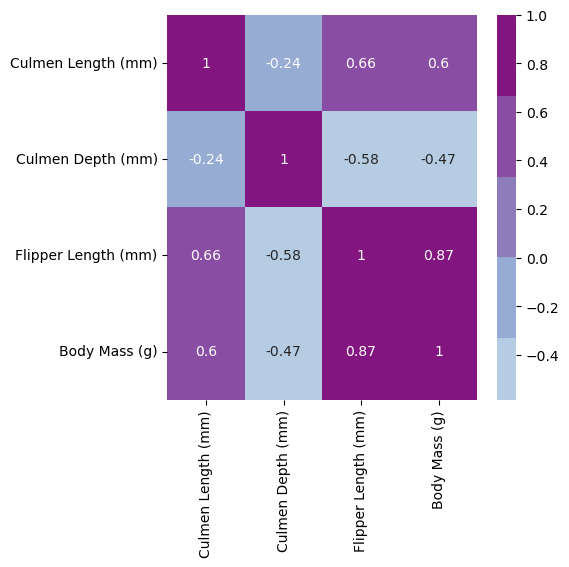

In [7]:
# Plot correlation heatmap
plt.figure(figsize=(5, 5))
ax = sns.heatmap(df[num_features].corr(),
                 xticklabels=df[num_features].corr().columns,
                 yticklabels=df[num_features].corr().columns,
                 cmap=sns.color_palette(palette='BuPu'),
                 center=0,
                 annot=True)


Correlation analysis of the penguins' body measurements shows a strong positive correlation between flipper length and body mass. Culmen length also presents a positive relationship with these two features. Culmen depth, however, is negatively correlated with all variables.

### Categorical features

Two of the dataset's features, Sex and Island, are categorical. To visualise them, count plots are presented below.

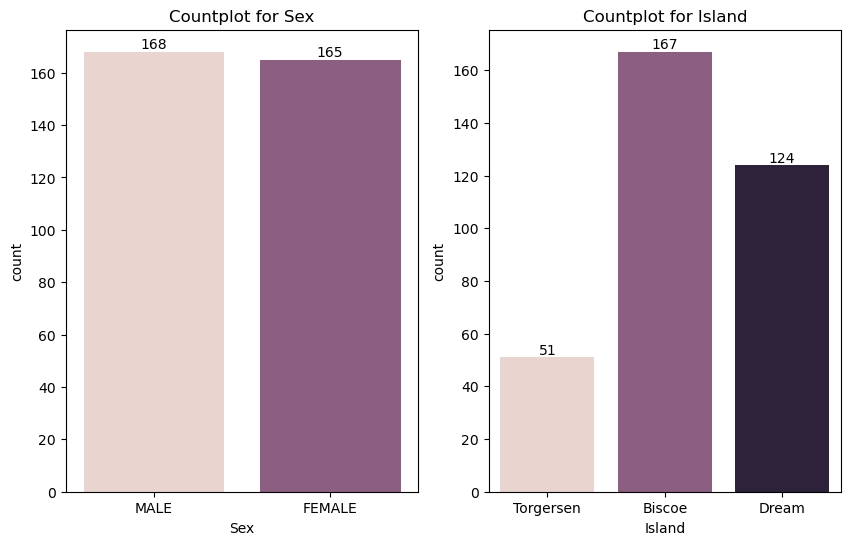

In [8]:
cat_features = ['Sex', 'Island']

fig, axs = plt.subplots(1,2, figsize=(10, 6))
for f, ax in zip(cat_features, axs.flat):
    count = sns.countplot(data=df, x=f, ax=ax, palette=palette)
    ax.bar_label(count.containers[0])
    ax.set_title(f"Countplot for {f}")
    
plt.show()


The proportion of male and female penguins is balanced, and their locations are distributed among three islands: Biscoe with 167, Dream with 124, and Torgersen with 51 observations. However, there is some missing information in the Sex column.

### Target variable

The countplot displays the number of animals assigned to each class. Class Adelie consists of 151 observations, Gentoo has 123, and Chinstrap has only 68 samples. The data is not balanced.

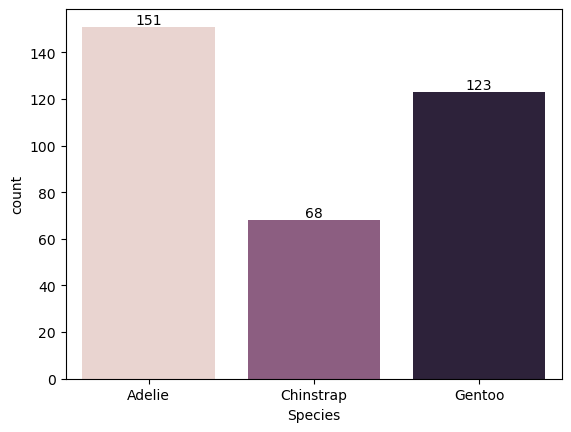

In [9]:
# Countplot of target variable
count = sns.countplot(data=df, x='Species', palette=palette)
plt.bar_label(count.containers[0])
plt.show()


### Multivariate analysis

The multivariate data analysis presents the relationship between the studied features and the class assignments. The plot shows clear group clustering based on the features used.

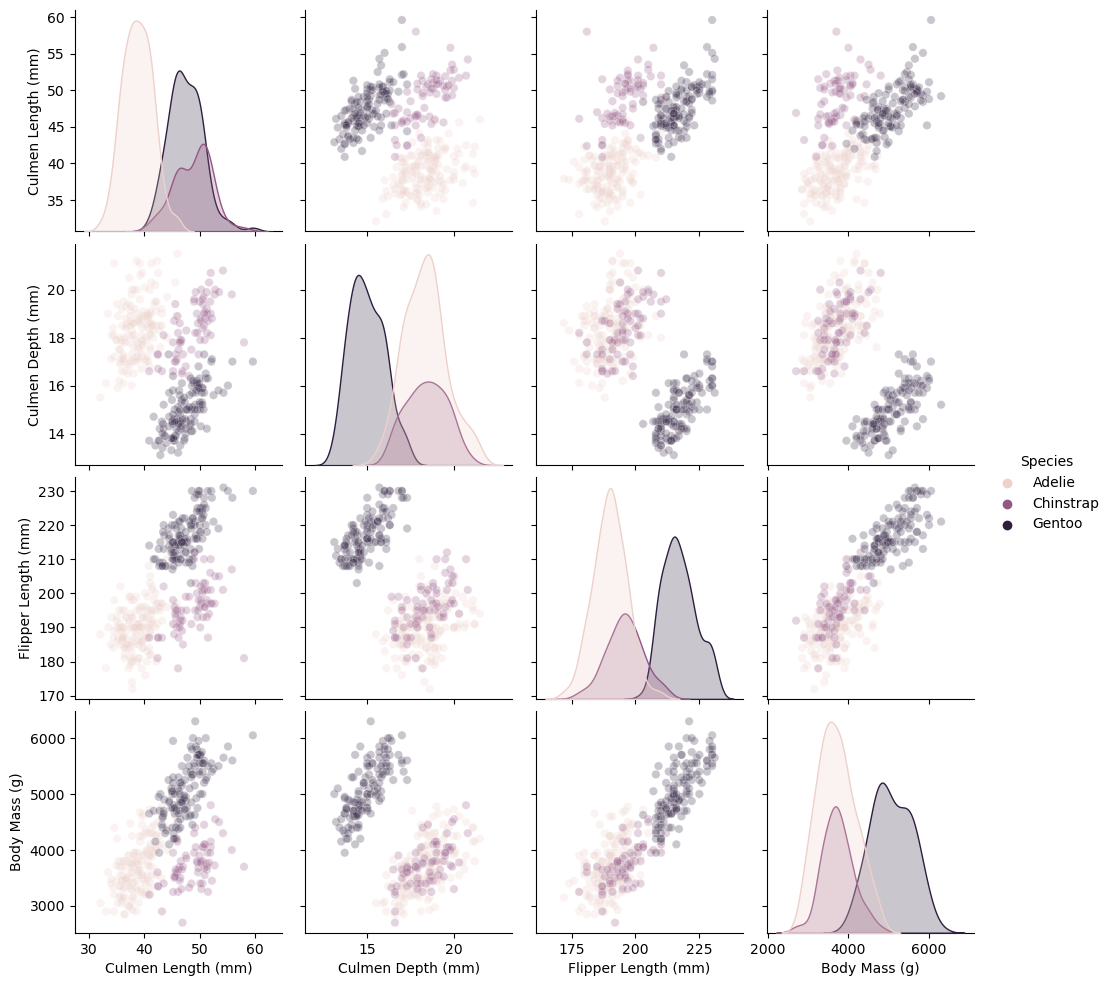

In [10]:
fig = sns.pairplot(df, kind='scatter', plot_kws={'alpha': 0.25}, hue='Species', palette=palette)
plt.show()

## Training/Tasting split
The features and target variables have been split into training and testing sets, with testing data accounting for 30% of the total. The data have been scaled to perform classification using parametric models such as Logistic Regression, K-Nearest Neighbours, and SVM.


In [11]:
# Separate data into feature matrix and target vector
X = df.drop(['Species'], axis=1).copy()
y = df['Species'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print('Training set:', X_train.shape, y_train.shape)
print('\nTesting set:', X_test.shape, y_test.shape)



Training set: (239, 6) (239,)

Testing set: (103, 6) (103,)


## Preprocessing of numerical and categorical data


In [12]:
# numerical features preprocessing
num_preprocessing = Pipeline(steps=[
    ('scalar', StandardScaler())
])

# categorical features preprocessing
cat_preprocessing = Pipeline(steps=[
    ('fill_missings', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(sparse_output=False ,handle_unknown='ignore'))
])

# transformer - combining numerical and categorical 
data_preprocessing = ColumnTransformer(transformers=[
    ('numeric_preprocessing', num_preprocessing, num_features),
    ('categorical_preprocessing', cat_preprocessing, cat_features)
])

# transformer - combine unscaled numerical and categorical
data_preprocessing_unscaled = ColumnTransformer(transformers=[
    ('categorical_preprocessing', cat_preprocessing, cat_features)],
    remainder='passthrough'
)

## Logistic Regression

The first model used to classify the penguin species is Logistic Regression, incorporating regularization methods: Lasso (l1) and Ridge (l2), with adjustments to the C parameter.

In [13]:
# Logistic Regression model fitting
model_pipeline_lr = Pipeline(steps=[('preprocessor', data_preprocessing),
                                    ('model', LogisticRegression(max_iter=10000))])
model_pipeline_lr.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric_preprocessing',
                                                  Pipeline(steps=[('scalar',
                                                                   StandardScaler())]),
                                                  Index(['Culmen Length (mm)', 'Culmen Depth (mm)', 'Flipper Length (mm)',
       'Body Mass (g)'],
      dtype='object')),
                                                 ('categorical_preprocessing',
                                                  Pipeline(steps=[('fill_missings',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Sex', 'Island'])])),
                ('model', LogisticRegression(max_iter=10000))])

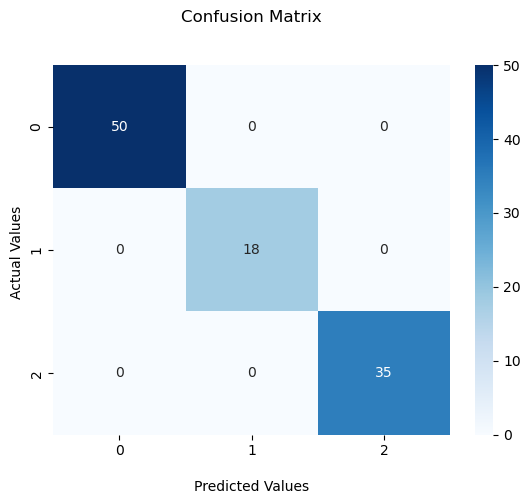

,Model,F1_score,Accuracy
0,Logistic Regression,1.0,1.0


In [14]:
calculate_metrics(model_pipeline_lr, 'Logistic Regression', X_test, y_test)

In [15]:
# Hyperparameters tunning
params = {
    'model__C': np.logspace(-4, 4, 9),
    'model__penalty' : ['l1', 'l2']
}

model_pipeline_lr_v2 = Pipeline(steps=[('preprocessor', data_preprocessing),
                                    ('model', LogisticRegression(max_iter=10000, solver='liblinear'))])
list(model_pipeline_lr_v2.get_params().keys())


grid_search = GridSearchCV(model_pipeline_lr_v2, params, cv=10, n_jobs=-1, verbose=0, scoring='f1_macro')
grid_search.fit(X_train, y_train)
print('Selected hyperparameters:', grid_search.best_params_)
model_lr_v2 = grid_search.best_estimator_

Selected hyperparameters: {'model__C': 10.0, 'model__penalty': 'l1'}


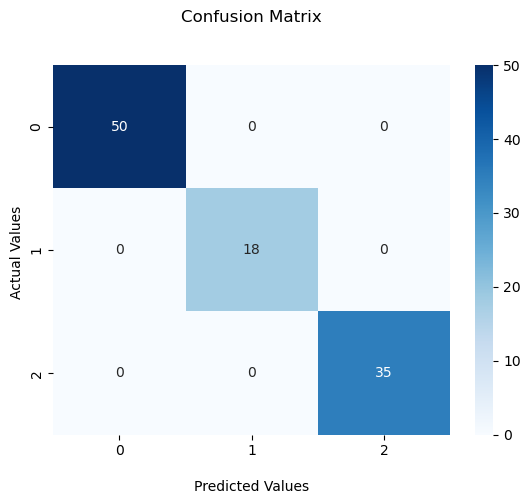

,Model,F1_score,Accuracy
0,Logistic Regression,1.0,1.0
0,Logistic Regression v2,1.0,1.0


In [16]:
calculate_metrics(model_lr_v2, 'Logistic Regression v2', X_test, y_test)

The best performance for the Logistic Regression model was observed without any regularization. The model perfectly classified all the testing data, achieving an excellent F1 score and an accuracy of 1 on the unseen data. In comparison to the previous version of the model we can see the improvment.

## K Nearest Neighbors

The KNeighbors model was applied to the same scaled training data with varying numbers of neighbors.

In [17]:
params_knn = {
    'model__n_neighbors': [i for i in range(1,9)]
}

model_pipeline_knn = Pipeline(steps=[('preprocessor', data_preprocessing),
                                    ('model', KNeighborsClassifier())])
model_pipeline_knn.fit(X_train, y_train)
list(model_pipeline_knn.get_params().keys())

# Hyperparameter tuning
grid_search = GridSearchCV(model_pipeline_knn, params_knn, cv=10, n_jobs=-1, verbose=0, scoring='f1_macro')
grid_search.fit(X_train, y_train)
print('Selected hyperparameters:', grid_search.best_params_)
model_knn = grid_search.best_estimator_


Selected hyperparameters: {'model__n_neighbors': 6}


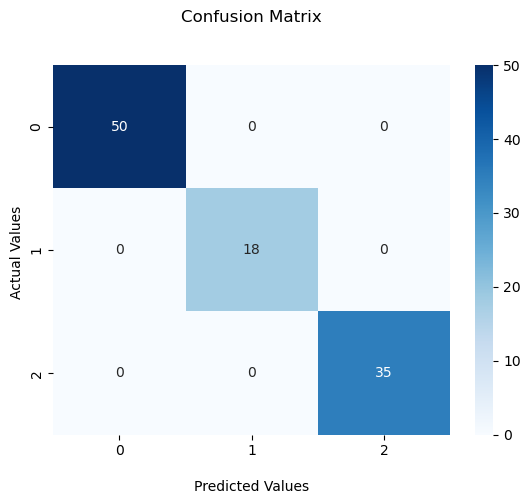

,Model,F1_score,Accuracy
0,Logistic Regression,1.0,1.0
0,Logistic Regression v2,1.0,1.0
0,KNeighbors,1.0,1.0


In [18]:
calculate_metrics(model_pipeline_knn, 'KNeighbors', X_test, y_test)


The best KNeighbors model from the grid search was found with n_neighbors=6. Its performance was evaluated on the testing data, and the classifier performed exceptionally well, correctly classifying all penguin species.

## SVM 

The next parametric model applied to the data is the Support Vector Machine (SVM). Using the GridSearch function, different kernel methods and various values for the C hyperparameter were tested to find the best performing model.

In [19]:
param_svm = {
    'model__C':[1e-2, 1e-1, 1, 10, 100],
    'model__kernel':['linear', 'poly', 'rbf', 'sigmoid']
}

model_pipeline_svm = Pipeline(steps=[('preprocessing',data_preprocessing),
                                     ('model', SVC(random_state=42))])
model_pipeline_svm.fit(X_train, y_train)

grid_search = GridSearchCV(estimator=model_pipeline_svm, param_grid=param_svm,
                           scoring="f1_macro", cv=10, verbose=0, n_jobs=-1)

grid_search.fit(X_train, y_train)
print('Selected hyperparameters: ', grid_search.best_params_)
model_svm = grid_search.best_estimator_



Selected hyperparameters:  {'model__C': 10, 'model__kernel': 'poly'}


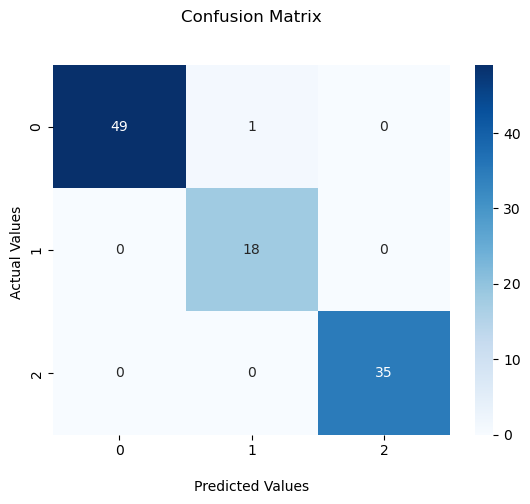

,Model,F1_score,Accuracy
0,Logistic Regression,1.000000,1.000000
0,Logistic Regression v2,1.000000,1.000000
0,KNeighbors,1.000000,1.000000
0,SVM,0.987624,0.990291


In [20]:
calculate_metrics(model_svm, "SVM", X_test, y_test)

The final SVM model, using the poly kernel and a C hyperparameter value of 10, achieved an F1 score of 0.988, with only one misclassified sample.

## Random Forest

The Random Forest model with three hyperparameters (n_estimators, max_depth, and min_samples_leaf) was trained using GridSearch on unscaled feature data.

In [21]:
params_rf = {
    'model__n_estimators':[50,100,200,500],
    'model__max_depth':[3,5,7,9,12],
    'model__min_samples_leaf':[3,5,8,10,15]
}

model_pipeline_rf = Pipeline(steps=[
    ('data preprocessing', data_preprocessing_unscaled),
    ('model', RandomForestClassifier(random_state=42))
])
model_pipeline_rf.fit(X_train, y_train)

grid_search = GridSearchCV(estimator=model_pipeline_rf, param_grid=params_rf,
                           cv=10, n_jobs=-1, verbose=0, scoring='f1_macro')
grid_search.fit(X_train, y_train)
print("Selected hyperparameters:", grid_search.best_params_)
model_rf = grid_search.best_estimator_


Selected hyperparameters: {'model__max_depth': 5, 'model__min_samples_leaf': 3, 'model__n_estimators': 50}


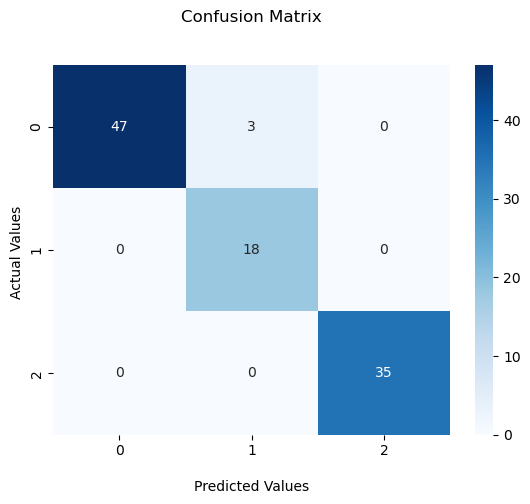

,Model,F1_score,Accuracy
0,Logistic Regression,1.000000,1.000000
0,Logistic Regression v2,1.000000,1.000000
0,KNeighbors,1.000000,1.000000
0,SVM,0.987624,0.990291
0,Random Forest,0.964050,0.970874


In [22]:
calculate_metrics(model_rf, "Random Forest", X_test, y_test)

The F1 score of 0.964 was achieved for the test dataset. However, it's evident that the parametric models are consistently achieving higher scores.

## AdaBoost


The AdaBoost ensemble, based on the best Decision Tree hyperparameters chosen by the Random Forest algorithm, was trained as shown below. Additionally, different values for n_estimators were implemented to enhance the model's performance.

In [23]:
# AdaBoost using best decision tree
params_ada = {
    'model__n_estimators': [50,100, 200, 500]
}

model_ada_init = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=5, min_samples_leaf=3, random_state=42))

model_pipeline_ada = Pipeline(steps=[
    ('data preprocessing', data_preprocessing_unscaled),
    ('model', model_ada_init)
])
model_pipeline_ada.fit(X_train, y_train)



grid_search = GridSearchCV(estimator=model_pipeline_ada, param_grid=params_ada,
                           cv=10, n_jobs=-1, verbose=0, scoring='f1_macro')
grid_search.fit(X_train, y_train)
print("Selected hyperparameters:", grid_search.best_params_)
model_ada = grid_search.best_estimator_

Selected hyperparameters: {'model__n_estimators': 500}


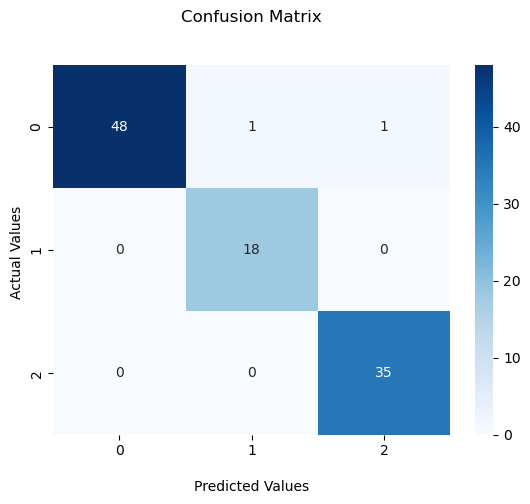

,Model,F1_score,Accuracy
0,Logistic Regression,1.000000,1.000000
0,Logistic Regression v2,1.000000,1.000000
0,KNeighbors,1.000000,1.000000
0,SVM,0.987624,0.990291
0,Random Forest,0.964050,0.970874
0,AdaBoost,0.979493,0.980583


In [24]:
calculate_metrics(model_ada, "AdaBoost", X_test, y_test)

The final F1 score was 0.988, indicating an improvement compared to the Random Forest. However, all the parametric models (Logistic Regression, KNeighbors, and SVC) performed perfectly on the unseen data, achieving accuracies and F1 scores of 1. Compared to the initial implementation, all the models improved their performance. This improvement might be due to the inclusion of the categorical features (Sex and Island), which had not been considered before.